
# Influence of 14N on 13C NMR MAS spectra of glycine


> This notebook contains code adapted from the mrsimulator examples repository (https://github.com/mrsimulator/mrsimulator).
> See LICENSE-THIRD-PARTY.md for the BSD 3-Clause license details.

The alpha-carbon resonance of glycine, 13C (I=1/2), attached to 14N (I=1).
The 14N quadrupolar tensor parameters were obtained from Hexem et al. [1](#f1).


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mrsimulator import Simulator, SpinSystem, Site, Coupling
from mrsimulator.method.lib import BlochDecaySpectrum
from mrsimulator import signal_processor as sp
from mrsimulator.spin_system.tensors import SymmetricTensor
from mrsimulator.method import SpectralDimension

Create a 13C-14N coupled spin system.



In [2]:
from ase.io import read
from soprano.selection import AtomSelection
from soprano.properties.nmr import get_spin_system, EFGTensor, DipolarTensor

# Crystalline glycine:
atoms = read("../example_data/glycine/crystalline/glycin25_nmr.magres")
# Get relevant subset via indices
CN_sel = AtomSelection(atoms, [12,14]) # C2 and N1
atoms = CN_sel.subset(atoms)

# Extract spin system in MRSimulator format
magres_spin_system = get_spin_system(
            atoms,
            include_shielding=False,
            include_efg=True,
            include_dipolar=True,
            ).to_mrsimulator()


Now, in the spin system we just generated, the orientation of the EFG tensor on N1 and the dipolar tensor between C1 and N1 are given relative to the global coordinate system. However, in this case we just want the orientation of the EFG tensor with respect to the dipolar tensor - i.e. the orientation of the EFG tensor on N1 with respect to the C-N bond. We can get this using some Soprano functionality as follows:

In [3]:
# First extract the tensors:
efg = EFGTensor.get(atoms)[1] # EFG tensor for N1
dip = DipolarTensor.get(atoms)[(0,1)] # Dipolar tensor between C2 and N1

Now get the relative Euler angles between the two tensors, noting that there are, in general, 16 equivalent sets of Euler angles that can describe the relative orientation of two tensors. We are free to choose any of these sets.

In [4]:
equivalent_euler_angles = efg.equivalent_euler_to(dip)

print("The following Euler angles are equivalent to align the EFG and Dipolar tensors (deg):")
print(equivalent_euler_angles * 180 / np.pi)
efg_angles = equivalent_euler_angles[0] # Any of these would be fine. Let's use the first one
# We can zero out the dipolar tensor angles since we are only interested in the relative orientation
dip_angles = [0,0,0] 

# Edit the spin system angles manually:
# EFG angles - set to the first equivalent relative Euler angles
magres_spin_system["sites"][1]["quadrupolar"]["alpha"] = efg_angles[0]
magres_spin_system["sites"][1]["quadrupolar"]["beta"] = efg_angles[1]
magres_spin_system["sites"][1]["quadrupolar"]["gamma"] = efg_angles[2]

# Dipolar angles - set to zero
magres_spin_system["couplings"][0]["dipolar"]["alpha"] = dip_angles[0]
magres_spin_system["couplings"][0]["dipolar"]["beta"] = dip_angles[1]
magres_spin_system["couplings"][0]["dipolar"]["gamma"] = dip_angles[2]





The following Euler angles are equivalent to align the EFG and Dipolar tensors (deg):
[[ -0.           7.55890461 216.36158111]
 [180.         172.44109539 143.63841889]
 [180.         172.44109539 323.63841889]
 [ -0.           7.55890461  36.36158111]
 [  0.         172.44109539  36.36158111]
 [180.           7.55890461 323.63841889]
 [180.           7.55890461 143.63841889]
 [  0.         172.44109539 216.36158111]
 [180.         172.44109539  36.36158111]
 [  0.           7.55890461 323.63841889]
 [  0.           7.55890461 143.63841889]
 [180.         172.44109539 216.36158111]
 [180.           7.55890461 216.36158111]
 [ -0.         172.44109539 143.63841889]
 [ -0.         172.44109539 323.63841889]
 [180.           7.55890461  36.36158111]]


We end up with the following spin system based on the magres file:

In [5]:
magres_spin_system

{'sites': [{'isotope': '13C', 'label': 'C2'},
  {'isotope': '14N',
   'label': 'N1',
   'quadrupolar': {'Cq': 1495258.3309293762,
    'eta': 0.4769699014926341,
    'alpha': -0.0,
    'beta': 0.13192777333949862,
    'gamma': 3.7762219651381095}}],
 'couplings': [{'dipolar': {'D': -680.4752305595654,
    'alpha': 0,
    'beta': 0,
    'gamma': 0},
   'site_index': [0, 1]}]}

The spin system from the MRSimulator example is as follows:

In [6]:
spin_system = SpinSystem(
    sites=[
        Site(isotope="13C", isotropic_chemical_shift=0.0),
        Site(
            isotope="14N",
            isotropic_chemical_shift=0,  # in ppm
            quadrupolar=SymmetricTensor(
                Cq=1.18e6,  # in Hz
                eta=0.54,
                alpha=0,
                beta=5 * np.pi / 180,
                gamma=0,
            ),
        ),
    ],
    couplings=[Coupling(site_index=[0, 1], dipolar=SymmetricTensor(D=-660.2))],
)

Create a BlochDecaySpectrum method.



In [7]:
method = BlochDecaySpectrum(
    channels=["13C"],
    magnetic_flux_density=3.5338,  # in T
    rotor_frequency=12000,  # in Hz
    spectral_dimensions=[SpectralDimension(count=2048, spectral_width=200)],
)

Create the Simulator objects and add the method and the spin system objects. 



In [8]:
magres_sim = Simulator(spin_systems=[magres_spin_system], methods=[method])
sim = Simulator(spin_systems=[spin_system], methods=[method])

magres_sim.config.integration_volume = "hemisphere"
sim.config.integration_volume = "hemisphere"

# Run both simulations
magres_sim.run()
sim.run()

Add post-simulation signal processing.



In [9]:
processor = sp.SignalProcessor(
    operations=[
        sp.IFFT(),
        sp.apodization.Gaussian(FWHM="1 Hz"),
        sp.FFT(),
    ]
)

magres_processed_dataset = processor.apply_operations(dataset=magres_sim.methods[0].simulation)
magres_processed_dataset.dimensions[0].to("Hz")

processed_dataset = processor.apply_operations(dataset=sim.methods[0].simulation)
processed_dataset.dimensions[0].to("Hz")

Plot the spectra

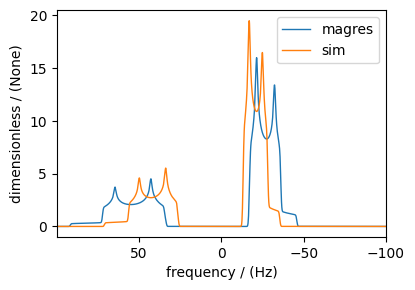

In [10]:
plt.figure(figsize=(4.25, 3.0))
ax = plt.subplot(projection="csdm")
ax.plot(magres_processed_dataset.real, color="C0", linewidth=1, label="magres")
ax.plot(processed_dataset.real, color="C1", linewidth=1, label="sim")
ax.invert_xaxis()
ax.legend()
plt.tight_layout()
plt.show()

## References

[1] Hexem, J. G., Frey, M. H., and Opella, S. J., Influence of
     $^{14}\text{N}$ on $^{13}\text{C}$ NMR Spectra of Solids, J. Am.
     Chem. Soc., 1981, **103**, 224-226.
     [DOI: 10.1021/ja00391a057](https://doi.org/10.1021/ja00391a057)

